<h2><u>Question-2</u></h2>

<h4>Training CNN from scratch</h4>

In [1]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import numpy as  np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

directory = "/kaggle/input/utkface-new/UTKFace"
files = [f for f in os.listdir(directory) if f.endswith('.jpg')]
ages = []
dataset = []
for f in files:
    age = float(f.split('_')[0])  # [age]_[gender]_[race]_[datetime].jpg
    image_path = os.path.join(directory, f)
    ages.append((image_path, age))

for path, age in ages:
    image = Image.open(path).convert('RGB')
    image = transform(image)
    dataset.append((image, age))

print(len(dataset))

23708


In [3]:
train, test = train_test_split(dataset, test_size=0.2, random_state=45)
print("Train:", len(train))
print("Test:", len(test))

Train: 18966
Test: 4742


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 224 -> 112
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # 112 -> 56
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)   #  56 -> 28
        )
        
        self.regressor = nn.Sequential(
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.regressor(x)
        return x

class ListDataset(Dataset):
    def __init__(self, data_list):
        self.data_list = data_list
        
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        return self.data_list[idx]

In [5]:
batch_size = 32
train_loader = DataLoader(ListDataset(train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(ListDataset(test), batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

cnn_loss = []
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    temp_loss = 0.0
    for images, ages in train_loader:
        images = images.to(device)
        ages = ages.to(device).float().unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, ages)
        loss.backward()
        optimizer.step()
        
        temp_loss += loss.item() * images.size(0)
    train_loss = temp_loss / len(train_loader.dataset)
    
    # Evaluation phase
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, ages in test_loader:
            images = images.to(device)
            ages = ages.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, ages)
            test_loss += loss.item() * images.size(0)
    test_loss /= len(test_loader.dataset)
    cnn_loss.append(test_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch [1/15], Training Loss: 284.0846, Test Loss: 166.6316
Epoch [2/15], Training Loss: 140.2144, Test Loss: 165.9586
Epoch [3/15], Training Loss: 111.3233, Test Loss: 105.8309
Epoch [4/15], Training Loss: 90.6981, Test Loss: 97.9398
Epoch [5/15], Training Loss: 78.1879, Test Loss: 88.5352
Epoch [6/15], Training Loss: 66.4808, Test Loss: 85.0357
Epoch [7/15], Training Loss: 56.4629, Test Loss: 82.7380
Epoch [8/15], Training Loss: 48.4474, Test Loss: 87.6421
Epoch [9/15], Training Loss: 38.4989, Test Loss: 97.8606
Epoch [10/15], Training Loss: 33.4558, Test Loss: 91.7567
Epoch [11/15], Training Loss: 25.5034, Test Loss: 92.8582
Epoch [12/15], Training Loss: 22.4478, Test Loss: 89.7157
Epoch [13/15], Training Loss: 18.8380, Test Loss: 87.4674
Epoch [14/15], Training Loss: 15.8688, Test Loss: 89.5586
Epoch [15/15], Training Loss: 14.6573, Test Loss: 88.5324


In [6]:
# model.eval()
# preds = []
# targets = []

# with torch.no_grad():
#     for images, ages in test_loader:
#         images = images.to(device)
#         ages = ages.to(device)
#         outputs = model(images)

#         preds.extend(outputs.cpu().numpy().flatten())
#         targets.extend(ages.cpu().numpy().flatten())

# preds = np.array(preds)
# targets = np.array(targets)

# mae = mean_absolute_error(targets, preds)
# mse = mean_squared_error(targets, preds)
# rmse = np.sqrt(mse)
# r2 = r2_score(targets, preds)

# print(f"Mean Absolute Error (MAE): {mae:.2f}")
# print(f"Mean Squared Error (MSE): {mse:.2f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
# print(f"R² Score: {r2:.2f}")

<h4>Pre-trained ResNET model</h4>

In [7]:
model_trained = models.resnet18(pretrained=True)
model_trained.fc = nn.Linear(model_trained.fc.in_features, 1)

model_trained = model_trained.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 210MB/s]


In [8]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model_trained.parameters(), lr=0.001)

resnet_loss = []
num_epochs = 15
for epoch in range(num_epochs):
    model_trained.train()
    temp_loss = 0.0
    for images, ages in train_loader:
        images = images.to(device)
        ages = ages.to(device).float().unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model_trained(images)
        loss = criterion(outputs, ages)
        loss.backward()
        optimizer.step()
        
        temp_loss += loss.item() * images.size(0)
    train_loss = temp_loss / len(train_loader.dataset)
    
    # Evaluation phase
    model_trained.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, ages in test_loader:
            images = images.to(device)
            ages = ages.to(device).float().unsqueeze(1)
            outputs = model_trained(images)
            loss = criterion(outputs, ages)
            test_loss += loss.item() * images.size(0)
    test_loss /= len(test_loader.dataset)
    resnet_loss.append(test_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch [1/15], Training Loss: 165.5699, Test Loss: 106.1466
Epoch [2/15], Training Loss: 78.8879, Test Loss: 75.0387
Epoch [3/15], Training Loss: 62.8998, Test Loss: 69.1843
Epoch [4/15], Training Loss: 54.7558, Test Loss: 69.5950
Epoch [5/15], Training Loss: 44.2050, Test Loss: 66.3018
Epoch [6/15], Training Loss: 36.1360, Test Loss: 55.8380
Epoch [7/15], Training Loss: 27.8429, Test Loss: 55.8495
Epoch [8/15], Training Loss: 23.2316, Test Loss: 56.9866
Epoch [9/15], Training Loss: 17.8052, Test Loss: 63.8069
Epoch [10/15], Training Loss: 16.1514, Test Loss: 57.3765
Epoch [11/15], Training Loss: 14.2506, Test Loss: 58.1561
Epoch [12/15], Training Loss: 11.3176, Test Loss: 55.8754
Epoch [13/15], Training Loss: 12.5199, Test Loss: 62.5552
Epoch [14/15], Training Loss: 10.6905, Test Loss: 56.6921
Epoch [15/15], Training Loss: 7.7011, Test Loss: 55.5869


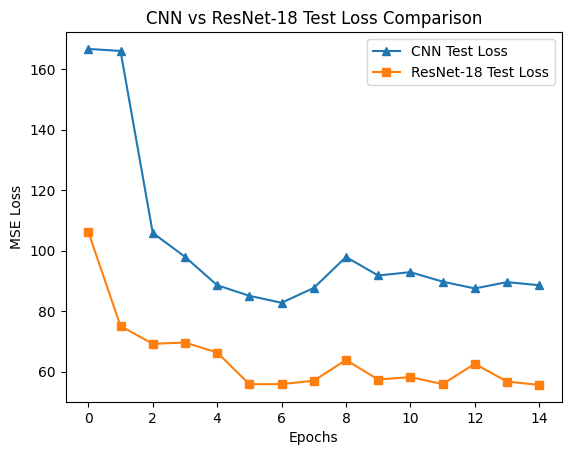

In [9]:
plt.figure()
plt.plot(range(0, 15), cnn_loss, label='CNN Test Loss', marker='^')
plt.plot(range(0, 15), resnet_loss, label='ResNet-18 Test Loss', marker='s')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("CNN vs ResNet-18 Test Loss Comparison")
plt.show()

<h4><u>Report</u></h4>

- The pretrained ResNet-18 model outperforms the CNN trained from scratch. This is because the ResNet-18 model has learned feature representations on the large ImageNet dataset. Even though the age regression task differs from the ImageNet classification task, the learned features (edges, textures, etc.) help the model extract more meaningful information from faces.
- This is called transfer learning and it allows for faster convergence and better initialization.
